# MALWARE USES MULTIPLE WEB SERVERS TO HAVE A PERIODIC HTTP C&C CONNECTION WHILE ITS NETFLOWS ARE NOT PERIODIC

In this assignment, we take a look at [Malware detection](https://mcfp.weebly.com/analysis), where we find an explicit analysis of tracking down a malware inducing SPAM.
The procedure is broken down step by step, and a thorough explanation of all steps is presented as follows, from the site previously cited:

 "While analyzing our capture CTU-Malware-Capture-Botnet-89-1 we found out that there were some strange issues with the periodicity of the C&C channels. In this capture there were a lot of HTTP connections, but few of them were periodic.
During the analysis of the network capture we usually start looking at the NetFlows and then we move to the payload data.
What we found is that several periodic HTTP connections had non-periodic NetFlows. This was strange for us so we took a deeper look."

## Checking Protocols Accessed 

In [ ]:
bot <- read.csv(file = "botnet.csv", header = TRUE)
botU <- bot[bot$Protocol == "UDP", ]
botT <- bot[bot$Protocol == "TCP", ]
botH <- bot[bot$Protocol == "HTTP", ]
## First look at the frequency of HTTP's
	Prots <- tapply(bot$Protocol, bot$Protocol)
	bot1 <- cbind(bot, Prots)
	#png(file = "Protocols_Frequency.png")
	op <- par(mfrow = c(2, 2), mar = c(3, 3, 2, 1))
		plot(x = bot1$Time, y = bot1$Prots,
	xlab="Time elapsed", ylab = "Protocols", main = "Protocols Frequency",
	xlim = c(0,500))
		plot(x = bot1$Time, y = bot1$Prots,
	xlab="Time elapsed", ylab = "Protocols", main = "Protocols Frequency",
	xlim = c(501,1000))
		plot(x = bot1$Time, y = bot1$Prots,
	xlab="Time elapsed", ylab = "Protocols", main = "Protocols Frequency",
	xlim = c(1001,1500))
		plot(x = bot1$Time, y = bot1$Prots,
	xlab="Time elapsed", ylab = "Protocols", main = "Protocols Frequency",
	xlim = c(1501,2000))
    par(op)
	#dev.off()

We get the following result through this procedure:
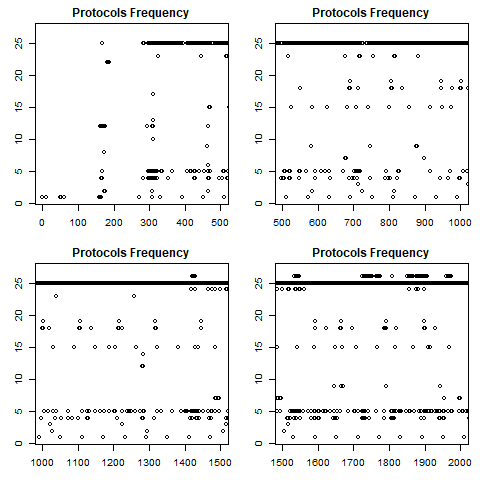

Row "5" indicates what we're looking for - the HTTP protocols.
We notice they have a relatively high frequency and exhibit normal behaviour so far, (perhaps too good of a clockwork periodicity in fact?)

In the original test of the CTU-Malware Botnet, the traffic captured looked as follows:
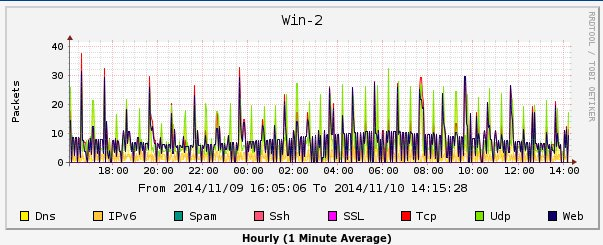

However, we will look at another aspect briefly, namely the HTTP's behaviour through the lengths of its requests over time:

In [ ]:
# png(file = "LengthsHTTP.png")
h <- bot1[bot1$Protocol == "HTTP", ]
plot(x=botH$Time, y = botH$Length, main = "Lengths of HTTP's over time",
ylab = "Packet length", xlab ="Time registered",
xlim = c(0, 15500), ylim = c(0, 10000),
pch = 16, cex = 0.8)
# dev.off()

This produces the following result: 

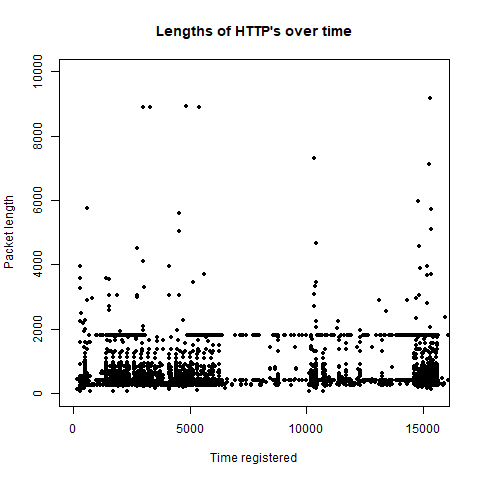

This is rather interesting and offers a quick and effective way of determining that we're most likely dealing with spam. The requests exhibit very precise boundaries of lengths (which is not, by any means, completely unexpected, yet still an indicator of potential SPAM requests and malicious activity)

## Digging into the data


We can now look at what exactly the requests are.
To do so, the botnet team first converted the pcap file to a web log file (using justsniffer) to see the HTTP requests better.
We will do it a bit differently with some code: 

In [ ]:
q <- grep("GET", botH$Info)
botH.fraud <- botH[q, ]
s <- head(botH.fraud$Info, 1000)
s1 <- gsub(".*GET |\\s.*", "", s)
# print(s1)

There's no need to print out the results, they are mostly as expected. We've only considered a small portion of the links, but among them are a few to be distinguished, since they direct to the same link seemingly periodically. *You should evidently NOT consider clicking on those links* 

We distinguish them as follows:

In [ ]:
q1 <- grep("GET /apps", botH$Info)
botH.f <- botH[q1, ]
botH.f <- botH.f[-(1:2), ]  ## The first 2 results were uninteresting and (very slightly) deviated from the periodicity
n <- nrow(botH.f)
j <- 1
i <- 1
c <- vector(length = n-1)
	while( j<= n-1 & i <= n-1) {
		c[j] <- as.numeric(botH.f$Time[i+1] - botH.f$Time[i])
		j <- j+1 
		i <- i+1}
head(c)
# 300.914334  
# 292.198524  
# 308.555492  
# 298.325984  
# 297.514960  
# 304.932015


The result above represents their periodicity. We simply computed the difference between timestamps and we printed it.
These differences were around 300 seconds, i.e. 5 minutes on average.
This indicates an organized SPAM which gets resent periodically.
The packets sent also exhibit very similar lengths.

In [ ]:
head(botH.f$Length, 5)
# 792
# 793
# 789
# 792
# 788


What about their NetFlows? To find out the NetFlows we extracted the IP addresses used in these requests and we sorted them by amount of requests. The results themselves (the exact IPs) are uninteresting, but what truly is interesting is that **the same URL was being requested alternatively to different IP addresses.** Once that the IP addresses were extracted, we generated their 4-tuples and see their periodicity. This is more thoroughly described in the [Hacklu 2014 presentation](https://www.researchgate.net/publication/267574541_Botnets_Behavioral_Patterns_in_the_Network_Analysis_Monitoring_Detection_and_Blocking_Presentation). To get the 4-tuples we first convert the pcap file to a bidirectional Argus file.

As it turns out, in our state-based behavioral model the letters for periodic flows are 'a' to 'f' and 'A' to 'F'. Considering that the letters in these previous states were mostly 's' and '0', we conclude that there are NO periodic flows in these connections. However, we know that the HTTP requests are periodic. So what happened? 

The answers to this problem is that the bot was sending HTTP requests to a specific URL, but the IP addresses assigned to the web server keep changing in some sort of load balancing schema. This is very common in normal applications, but in this case the malware is using a complex load balancing to have a periodic C&C HTTP connection. 


## Implications so far
The implications of this load balancing schema are that:

1) When researchers analyze network traffic, we tend to consider each connection separately. If the detection method is using NetFlows, it is most probably going to miss this periodicity.

2) If the web log analysis is using the IP address of the web server as an index, then it could be possible that the researcher will miss the connections to the rest of the IP addresses. 

3) Finally, we think that the owner of the malware is not aware of this complications because the load balancing seems to be designed to give more resilience to the botnet and not to hide the network patterns.

# MALWARE STARTED TO RANDOMIZE THE REQUEST TIMES IN RELATION WITH THEIR C&C CHANNELS

Later on in time, the behaviour of the packets changed. We recognized a malware that uses a DGA algorithm to find out the domains of their C&C servers. It became interesting when we noted that the DGA communication is **not using periodic requests on purpose.** In fact, it seems to be specifically generating the requests times of its DGA packets in order to avoid being periodic. The malware, which MD5 is c740789d5b226668f8a37626883fd0b7, is detected by AVAST as Win32:Dropper-KRG [Drp] and by Sophos as Mal/Steppa-A. The dataset where this behavior was found can be downloaded from [CTU-Malware Capture Botnet](https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-31/). 
We will be interested in the data which can be found there under "2013-11-25_capture-win7-3.192.35.51.30.port53.pcap". We save the wireshark capture ( **Make sure to have Wireshark installed to access this file** ) wherever, then follow the procedure:

1) Hit file at the top left corner of the screen > Extract Packet Dissections > As CSV ...

2) Save the file in your prefered directory under the file-name "Cap53.csv"

3) When transcribing the R-code, make sure to replace my pre-set work directory " # setwd("D://R-4.0.2//ExcelWorks") " with the directory you saved your "Cap53.csv" file in , e.g: "C://Downloads"

**Note** If you failed to follow Step 2 exactly as described, make sure to also change the file name when reading it in R. E.g If you instead named your file "Cap.csv" , you should "read.csv(file = "Cap.csv", header = T)" instead.

This specific data is a small extract of the whole data observed over several months, between Nov 2013 and Jan 2014 in our capture facility. The portion is particularly relevant, since in the capture file extracted it can be seen that there is a large group of packets going to the IP address 192.35.51.30, destination port 53/TCP. The content of these packets are DNS requests asking for domains being generated with a DGA.

In [ ]:
# setwd(D://R-4.0.2//ExcelWorks)
cap <- read.csv( file = "Cap53.csv", header = TRUE)
cap1 <- cap[cap$Destination == "192.35.51.30", ]
q <- grep("Standard query", cap1$Info)
cap2 <- cap1[q, ]
n <- nrow(cap2)
Sample <- c(1:n)
cap2 <- cbind(cap2, Sample)

Once again, astonishingly many of them have the same length, as it can be seen through a simple histogram:

In [ ]:
# png(file = "PackLength.png")
hist(head(cap2$Length, 500), main = "Lengths of packets", col = c(2,1,1,1,1,1))
# dev.off()

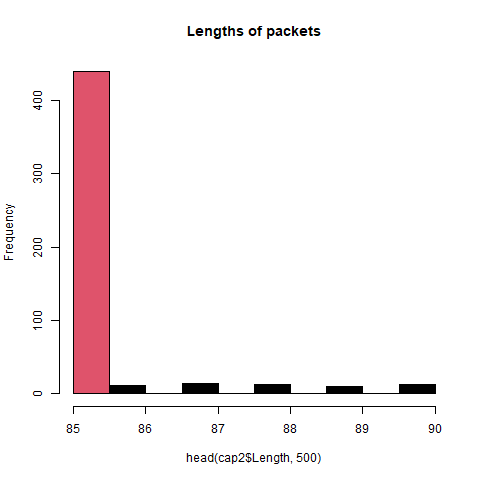

So, what are the sites generated by the DNS request? They're not particularly interesting, but worth noting for the record:

In [ ]:
l<- gsub(".*NS |\\s.*", "", cap2$Info)
head(unique(l), 3)
#  "kbzmyrj.net"      
#  "gczdamdbyahv.net" 
#  "dgcfpcofdwmt.net"
## These are just 3 of the length(unique(l)) == 73 such sites visited


These connections differentiate from a normal DNS requests because:

1) They use the TCP protocol instead of UDP.

2) They are being made to a DNS server chosen by the attacker and not to the one defined by the network. 

Even more, the simple trick of using TCP works well because some analysis tools, such as passivedns, fail to find the requests.
The analysis of all these DNS request using our behavioral state model (CCDetector.py tool) shows that the requests are not periodic.

In [ ]:
n <- nrow(cap2)
j <- 1
i <- 1
c <- vector(length = n-1)
	while( j<= n-1 & i <= n-1) {
		c[j] <- as.numeric(cap2$Time[i+1] - cap2$Time[i])
		j <- j+1 
		i <- i+1}
# png(file = "LostPer.png")
barplot(head(c,50), width = 1.1, space = NULL,
	angle = 45, col = rainbow(50), main = "Timelapse between occurences") 
# dev.off()

This is the result:
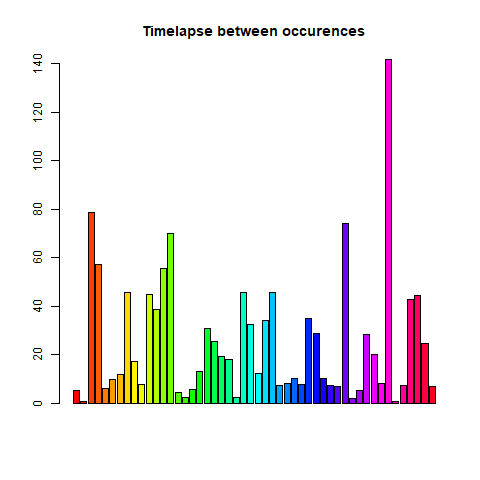

We do note that periodicity seems to have been lost now. The following are a sample of the flows sent in these DNS requests:

In [ ]:
r<- cbind(cap2$Time[-1], c)
T1 <- c(c(-1,-1), c)
t1 <- length(T1)
T1 <- T1[-((t1-1):t1)]
T2 <- c(-1, c)
t2 <- length(T2)
T2 <- T2[-t2]
        # identical(length(T1), length(T2), c) ## TRUE
T3 <- vector(length = length(c))
for(i in 1: length(c)) {
	T3[i] <- T2[i] - T1[i]
	}
k <- cbind(cap2$Time[-1], c, T1, T2, T3)
library(knitr)
kable(head(k, 50))

The columns mean:

"" = Initial time as it was measured

"c" = Time when the flow was seen.

T1 = "Time Difference 1-2": Time between the current flow and the previous one.

T2 = "Time Difference 2-3": Time between the previous flow and the 2nd previous flow. 

T3 = "Difference of Time Differences": Difference between Time Difference 1 and Time Difference 2.